# Setup

In [1]:

# import libraries

# basics
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from imblearn.over_sampling import SMOTE
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# basics for models
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# principal component analysis
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# k-means
from sklearn.cluster import KMeans

# knn
from sklearn.neighbors import KNeighborsClassifier

# logistic regression
from sklearn.linear_model import LogisticRegression

# support vector machine
from sklearn.svm import SVC

# decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# random forest
from sklearn.ensemble import RandomForestClassifier

# feedforward neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import metrics

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-03 15:43:00.730343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# set display settings

warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

# Import Tabular Data and Define Column Groups

In [3]:
# specify columns and datatypes, load full consolidated sdss dataset, and create class map

# load column names from file into a list
sdss_headers = pd.read_csv('../data/processed/sdss_full.csv.gz', compression='gzip', header=0, index_col=0, nrows=0).columns.tolist()

# specify column groups
object_identifiers = ['dr8objid']
galaxy_identifiers = ['gz2_filenumber']
object_locations = ['ra', 'dec']
class_label_names = ['sdss_clean_class_name', 'stellar_subclass_MK', 'gz2_subclass_hubble']
class_label_codes = ['sdss_clean_class_code', 'stellar_subclass_code', 'gz2_subclass_code']
galaxy_binary_labels = [label for label in sdss_headers if 'flag' in label]
galaxy_filters = ['petroR90_r_log']
object_features = ['redshift_log', 'sum_p', 'u-r_p', 'g-i_p', 'r-z_p']
star_features = ['elodie_color_index', 'elodie_temperature', 'elodie_metallicity']
# consider adding galaxy features:  ratio of petro_radius to petro_brightness

# create a datatype dictionary for object_identifiers
col_dtypes = {col: 'string' for col in object_identifiers + galaxy_identifiers}

# load full consolidated sdss dataset
sdss_primary = pd.read_csv('../data/processed/sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)

# create map between class label codes and class label names
sdss_clean_class_map = dict(zip(sdss_primary[class_label_names[0]], sdss_primary[class_label_codes[0]]))
stellar_subclass_map = dict(zip(sdss_primary[class_label_names[1]], sdss_primary[class_label_codes[1]]))
gz2_subclass_map = dict(zip(sdss_primary[class_label_names[2]], sdss_primary[class_label_codes[2]]))
class_code_maps = [sdss_clean_class_map, stellar_subclass_map, gz2_subclass_map]

/var/folders/w9/dx4nvr3j01s9jp6j1fm286vc0000gn/T/ipykernel_43900/1582399338.py:22: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  sdss_primary = pd.read_csv('../data/processed/sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)


# EDA - Investigate Classes and Features in Tabular Data

### Define and Call Helper Functions

In [4]:
# inspect the imported data

""" # display some data
display(sdss_primary.head(3))
display(sdss_primary.tail(3))
display(sdss_primary.sample(10))"""
 
# inspect dataframe
"""print(sdss_primary.shape)
print(sdss_primary.info())"""

'print(sdss_primary.shape)\nprint(sdss_primary.info())'

In [5]:
"""# investigate superclasses & simplified subclasses (categorical label names)

# create a helper function for investigating and plotting a subset from a column w/ categorical data
def investigate_clean_classes(df, column, filter=None):
    data = df[column]
    if filter:
        data = df[df['sdss_clean_class_name'] == filter][column]
    unclassified_count = data.isna().sum() + (data == 'unclassified').sum() + (data == 'unkonwn').sum()
    print(f"\n---------- {column} : {filter} ----------")
    print(f"The number of rows with classified values is: {len(data) - unclassified_count}")
    print(f"The number of unique labels is: {len(df[column].unique())}")
    data2 = data[data != 'unclassified']
    data2 = data2[data2 != 'unknown']
    plt.figure(figsize=(3, 2))
    sns.countplot(y=data2, order=data2.value_counts().index[:15], palette='viridis')
    #plt.suptitle(f"{column = }")
    #plt.tight_layout()
    plt.show()

investigate_clean_classes(sdss_primary, 'sdss_clean_class_name')
investigate_clean_classes(sdss_primary, 'gz2_subclass_hubble', 'galaxy')
investigate_clean_classes(sdss_primary, 'stellar_subclass_MK', 'star')"""

'# investigate superclasses & simplified subclasses (categorical label names)\n\n# create a helper function for investigating and plotting a subset from a column w/ categorical data\ndef investigate_clean_classes(df, column, filter=None):\n    data = df[column]\n    if filter:\n        data = df[df[\'sdss_clean_class_name\'] == filter][column]\n    unclassified_count = data.isna().sum() + (data == \'unclassified\').sum() + (data == \'unkonwn\').sum()\n    print(f"\n---------- {column} : {filter} ----------")\n    print(f"The number of rows with classified values is: {len(data) - unclassified_count}")\n    print(f"The number of unique labels is: {len(df[column].unique())}")\n    data2 = data[data != \'unclassified\']\n    data2 = data2[data2 != \'unknown\']\n    plt.figure(figsize=(3, 2))\n    sns.countplot(y=data2, order=data2.value_counts().index[:15], palette=\'viridis\')\n    #plt.suptitle(f"{column = }")\n    #plt.tight_layout()\n    plt.show()\n\ninvestigate_clean_classes(sdss_pri

In [6]:
"""# investigate histograms of feature columns, color-shaded by superclass

# generate a subset dataframe
df = sdss_primary[['sdss_clean_class_name'] + object_features + star_features]
df = df.sample(frac=0.5)

# define classes
classes = sdss_primary['sdss_clean_class_name'].unique()

# set a color palette with distinct colors for each category
colors = sns.color_palette('bright', n_colors=len(df['sdss_clean_class_name'].unique()))

# iterate over columns and create separate plots
for col in object_features + star_features:
    plt.figure(figsize=(3, 2))
    plt.xscale('linear')
    log_choice = False
    denom = df[col].min()
    if denom == 0:
        denom = 0.001
    if abs(df[col].max() / denom) > 50:
        df[col] = df[col].replace(0, 0.001)
        log_choice = True
        plt.xscale('symlog')  
    for class_label, color in zip(classes, colors):
        if 'elodie' in col:
            if class_label == 'star':
                sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
        else:
            sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
    plt.title(col)
    plt.legend()
    plt.show()"""

"# investigate histograms of feature columns, color-shaded by superclass\n\n# generate a subset dataframe\ndf = sdss_primary[['sdss_clean_class_name'] + object_features + star_features]\ndf = df.sample(frac=0.5)\n\n# define classes\nclasses = sdss_primary['sdss_clean_class_name'].unique()\n\n# set a color palette with distinct colors for each category\ncolors = sns.color_palette('bright', n_colors=len(df['sdss_clean_class_name'].unique()))\n\n# iterate over columns and create separate plots\nfor col in object_features + star_features:\n    plt.figure(figsize=(3, 2))\n    plt.xscale('linear')\n    log_choice = False\n    denom = df[col].min()\n    if denom == 0:\n        denom = 0.001\n    if abs(df[col].max() / denom) > 50:\n        df[col] = df[col].replace(0, 0.001)\n        log_choice = True\n        plt.xscale('symlog')  \n    for class_label, color in zip(classes, colors):\n        if 'elodie' in col:\n            if class_label == 'star':\n                sns.histplot(df[df['sdss

# Define Helper Functions for Tabular Data

In [7]:
# define a helper function to extract only objects of interest, given a specified set of classes

def jsm_specify_objects(objects='galaxies', min_set_size=1000):
    
    # return secondary dataset containing only defined objects
    if objects == 'superclass':
        class_code_column = class_label_codes[0:1] #'sdss_clean_class_code'
        class_name_column  = class_label_names[0]
    elif objects == 'stars':
        class_code_column = class_label_codes[1:2] #'stellar_subclass_MK'
        class_name_column  = class_label_names[1]
    elif objects == 'galaxies':
        class_code_column = class_label_codes[2:3] #'gz2_subclass_hubble'
        class_name_column  = class_label_names[2]
    
    # drop rows corresponding to unclassified objects
    sdss_secondary = sdss_primary[sdss_primary[class_name_column] != 'unclassified']
        
    # drop rows corresponding to label that fall below the minimum set size for each label
    label_counts = sdss_secondary[class_name_column].value_counts()
    labels_to_drop = label_counts[label_counts < min_set_size].index
    sdss_secondary = sdss_secondary[~sdss_secondary[class_name_column].isin(labels_to_drop)]
    
    # replace the code values with a sequence of integers
    sdss_secondary[class_code_column[0]] = pd.factorize(sdss_secondary[class_code_column[0]])[0]

    # define label codes and names as well as a mapping dictionary
    df_unique = sdss_secondary[[class_code_column[0], class_name_column]].drop_duplicates()
    df_unique = df_unique.sort_values(by=class_code_column[0])
    label_map = dict(zip(df_unique[class_code_column[0]], df_unique[class_name_column]))
    label_codes = list(label_map.keys())
    label_names = list(label_map.values())
    
    return class_code_column, sdss_secondary, label_map, label_codes, label_names

In [8]:
# define a helper function to facilitate rebalancing -- shuffle only ('none'), sample equal numbers of least-common label ('equal'), or apply SMOTE ('smote')

def jsm_rebalance(X, y, class_column, mode='none'):
    
    indices = X.index.tolist()
    random.shuffle(indices)
    X_resampled = X.loc[indices]
    y_resampled = y.loc[indices]
    
    if mode == 'rarest':
        grouped_df = X_resampled.groupby(y_resampled[class_column[0]], group_keys=False)
        X_resampled = grouped_df.apply(lambda x: x.sample(min(len(x), y_resampled[class_column].value_counts().min())))
        y_resampled = y_resampled.loc[X_resampled.index]
        X_resampled = X_resampled.reset_index(drop=True)
        y_resampled = y_resampled.reset_index(drop=True)
    elif mode == 'smote':
        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)
    
    return X_resampled, y_resampled


In [9]:
# define a helper function to split into subsets using either np/pd or sklearn

def jsm_split_subsets(df, feature_cols, label_cols, ratios, mode='default', seed=38):
    
    np.random.seed(seed)
    train_ratio = ratios[0]
    validation_ratio = ratios[1]
    test_ratio = ratios[2]
    
    if mode == 'default':
        num_rows = df.shape[0]
        indices = np.random.permutation(num_rows)
        train_end = int(train_ratio * num_rows)
        validation_end = int((train_ratio + validation_ratio) * num_rows)
        train_indices = indices[:train_end]
        validation_indices = indices[train_end:validation_end]
        test_indices = indices[validation_end:]
        train_set = df.iloc[train_indices]
        validation_set = df.iloc[validation_indices]
        test_set = df.iloc[test_indices]
    elif mode == 'sklearn':
        train_set, temp_set = train_test_split(df, test_size=(1 - train_ratio))
        validation_set, test_set = train_test_split(temp_set, test_size=test_ratio/(validation_ratio + test_ratio))
    
    X_train = train_set[feature_cols]
    y_train = train_set[label_cols]
    X_validation = validation_set[feature_cols]
    y_validation = validation_set[label_cols]
    X_test = test_set[feature_cols]
    y_test = test_set[label_cols]
    
    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [10]:
# define a helper function perform PCA on a given data subset and visualize train results (esp. feature importance)

def pca_features(X, features):
    
    # fit the object_identifiers to a PCA model
    pca = PCA().fit(X)
    #print(type(pca))

    # evaluate the PCA loadings
    loadings = pd.DataFrame(
        data=pca.components_.T * np.sqrt(pca.explained_variance_ratio_), 
        columns=[f'PC{i}' for i in range(1, len(features) + 1)],
        index=features
    )
    loadings.head()
    
    # display some data
    """print(loadings.shape)
    display(loadings.head(5))"""
    
    # plot the cumulative variance by # of principal components
    # NOTE: the first PC already explaines ~80% of the total variance in the dataset
    plt.figure(figsize=(3,2))
    plt.plot(pca.explained_variance_ratio_.cumsum())
    plt.title('Cumulative % variation explained by principal components)', size=12)
    plt.show()

    # visualize correlations between first PC and object_features
    pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
    pc1_loadings = pc1_loadings.reset_index()
    pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']
    plt.figure(figsize=(3,2))
    plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
    plt.title('PCA loading scores (first principal component)', size=12)
    plt.xticks(rotation='vertical')
    plt.show()

    # visualize correlations between second PC and object_features
    pc2_loadings = loadings.sort_values(by='PC2', ascending=False)[['PC2']]
    pc2_loadings = pc2_loadings.reset_index()
    pc2_loadings.columns = ['Attribute', 'CorrelationWithPC1']
    plt.figure(figsize=(3,2))
    plt.bar(x=pc2_loadings['Attribute'], height=pc2_loadings['CorrelationWithPC1'], color='#087E8B')
    plt.title('PCA loading scores (second principal component)', size=12)
    plt.xticks(rotation='vertical')
    plt.show()
    
    return loadings

In [11]:
# define a helper function to create pandas dataframe for visualizing the model in scatter and tabular formats: X7_train (ndarray) --> pca_examples_table (df)

def pca_examples(X_ndarray, y_df, class_column):    
    
    # convert ndarray to pd df holding PC features
    temp1 = pd.DataFrame(data=X_ndarray, columns=['PC1','PC2','PC3'])
    temp1.reset_index(drop=True, inplace=True)

    # add labeled rows to df
    temp2 = y_df[class_column]
    temp2.reset_index(drop=True, inplace=True)
    
    # resample the pca dataframe
    pca_df = pd.concat([temp1, temp2], axis=1)
    pca_df = pca_df.sample(frac=0.5)
    
    # display some data
    """print(pca_df.shape)
    display(pca_df.head(5))"""
    
    # generate a scatterplot of the first two PC's from the df
    pca_df = pca_df.sample(frac=0.1)
    plt.figure(figsize=(5,4))
    for class_code in pca_df[class_column[0]].unique():
        label_name = label_map[class_code]
        class_data = pca_df[pca_df[class_column[0]] == class_code]
        plt.scatter(class_data['PC1'], class_data['PC2'], label=f'Class {label_name}', cmap='viridis', s=1, alpha=0.5)
        plt.title('Scatter along principal components')
    plt.title('Scatter along first two principal components')
    plt.legend()
    plt.show()

    # generate a 3d scatterplot of the first three PC's from the df
    fig = plt.figure().add_subplot(projection='3d')
    for class_code in pca_df[class_column[0]].unique():
        label_name = label_map[class_code]
        class_data = pca_df[pca_df[class_column[0]] == class_code]
        fig.scatter(class_data['PC2'], class_data['PC3'], class_data['PC1'], label=f'Class {label_name}', cmap='viridis', s=3, alpha=0.4)
    plt.title('Scatter along first three principal components')
    plt.legend()
    plt.show()
    
    return pca_df

In [12]:
# define a helper function to retrieve model names

def return_variable_name(obj):
    
    for k, v in globals().items():
        if v is obj:
            return k

In [13]:
# define a helper function to load existing or save new model

def jsm_fit_model(model, objects, X, y, X0_validation, y_validation, mode='load', epochs=1, batch_size=None, verbose=2):
    
    model_name = return_variable_name(model)
    
    if mode == 'load':
        if any(isinstance(model, cls) for cls in [sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin]):
            model = pickle.load(open(f"../models/model_{objects}_{model_name}.sav", 'rb'))
            history = None
        elif isinstance(model, keras.models.Sequential):
            model = tf.keras.models.load_model(f"../models/model_{objects}_{model_name}.h5")
            history = pickle.load(open(f"../models/model_{objects}_{model_name}_history.sav", 'rb'))
    elif mode == 'save':
        if any(isinstance(model, cls) for cls in [sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin]):
            model = model.fit(X, y)
            history = None
            pickle.dump(model, open(f"../models/model_{objects}_{model_name}.sav", 'wb'))
        elif isinstance(model, keras.models.Sequential):
            history = model.fit(X, y, validation_data=(X0_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=verbose)
            model.save(f"../models/model_{objects}_{model_name}.h5", overwrite=True, include_optimizer=True, save_format='h5')
            #json.dump(history.history, open(f"../models/model_{objects}_{model_name}_history.json", 'w'))
            pickle.dump(history.history, open(f"../models/model_{objects}_{model_name}_history.sav", 'wb'))
            history = history.history
    
    """print(f"{type(model) = }")
    print(f"{type(history) = }")"""
    
    return model, history

In [14]:
# define a helper function to make predictions using a model print

def jsm_predict(model, X, y):

    #print(X.shape)
    y_pred = model.predict(X)
    
    if isinstance(model, keras.models.Sequential):
        y_pred = np.argmax(y_pred, axis=-1)
    
    acs = accuracy_score(y, y_pred)
    ps = precision_score(y, y_pred, average='weighted')
    rs = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    metric = {"Accuracy Score": acs, "Precision Score": ps, "Recall Score": rs, "F1 Score": f1}
    print(metric)
    
    y_label_names = y[class_column[0]].map(label_map).to_frame(name=class_column[0])
    y_pred_label_names = np.vectorize(label_map.get)(y_pred)
    
    class_report = classification_report(y_label_names, y_pred_label_names)
    print(class_report)
    
    #print(type(y))
    #print(type(y_pred))
    
    cm = confusion_matrix(y_label_names, y_pred_label_names)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=label_names).plot()
    plt.show()

In [15]:
# define a helper function to plot train/validation performance of keras models

def jsm_plot_history(hist):
    
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

# Preprocessing Tabular Data

### Specify object set for classification

In [16]:
# specify secondary dataset based on inclusion of all objects ('superclass'), only labeled galaxies ('galaxies'), or only labeled stars ('stars')

objects = 'galaxies'

class_column, sdss_secondary, label_map, label_codes, label_names = jsm_specify_objects(objects, min_set_size=1000)
print(f"\n{class_column = }")
display(sdss_secondary.head(5))
print(f"{label_map = }")
print(f"{label_codes = }")
print(f"{label_names = }")

if objects == 'stars':
    features = object_features + star_features
else:
    features = object_features


class_column = ['gz2_subclass_code']


,dr8objid,gz2_filenumber,ra,dec,sdss_clean_class_name,sdss_clean_class_code,stellar_subclass_MK,stellar_subclass_code,gz2_subclass_hubble,gz2_subclass_code,gz1_flag_spiral,gz1_flag_elliptical,gz1_flag_uncertain,gz2_flag_smooth,gz2_flag_features_or_disk,gz2_flag_star_or_artifact,gz2_flag_edgeon_yes,gz2_flag_edgeon_no,gz2_flag_bar_yes,gz2_flag_bar_no,gz2_flag_spiral_yes,gz2_flag_spiral_no,gz2_flag_bulge_none1,gz2_flag_bulge_small,gz2_flag_bulge_medium,gz2_flag_bulge_large,gz2_flag_odd_yes,gz2_flag_odd_no,gz2_flag_round_circular,gz2_flag_round_medium,gz2_flag_round_cigar,gz2_flag_feature_ring,gz2_flag_feature_lens_or_arc,gz2_flag_feature_disturbed,gz2_flag_feature_irregular,gz2_flag_feature_other,gz2_flag_feature_merger,gz2_flag_feature_dust_lane,gz2_flag_bulge_round,gz2_flag_bulge_boxy,gz2_flag_bulge_none2,gz2_flag_arms_tight,gz2_flag_arms_medium,gz2_flag_arms_loose,gz2_flag_arms_1,gz2_flag_arms_2,gz2_flag_arms_3,gz2_flag_arms_4,gz2_flag_arms_many,gz2_flag_arms_unsure,petroR90_r_log,redshift_log,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
0,1237651252584448100,192933,236.355530,54.820911,galaxy,0,unclassified,8,SBc,0,True,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2.263365,-2.299111,85.88830,2.09786,1.09673,0.63014,NaN,NaN,NaN
2,1237651252584251555,32264,235.891464,55.133472,galaxy,0,unclassified,8,SBc,0,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.352307,-2.803127,77.52239,2.37586,1.12715,0.67207,NaN,NaN,NaN
3,1237651252584317089,32265,236.063721,55.035847,galaxy,0,unclassified,8,Sc,1,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.218923,-2.673609,84.18209,1.77608,0.65633,0.23047,NaN,NaN,NaN
5,1237651252584317111,192932,236.013229,54.984837,galaxy,0,unclassified,8,Sd,2,False,False,True,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.635344,-2.623476,85.25946,1.32251,0.54545,0.34388,NaN,NaN,NaN
8,1237655130907214001,249746,236.117706,54.700016,galaxy,0,unclassified,8,Sc,1,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.055423,-2.300338,80.71925,1.99366,0.98866,0.62453,NaN,NaN,NaN


label_map = {0: 'SBc', 1: 'Sc', 2: 'Sd', 3: 'Ee', 4: 'Sb', 5: 'SBb', 6: 'Er', 7: 'Ec'}
label_codes = [0, 1, 2, 3, 4, 5, 6, 7]
label_names = ['SBc', 'Sc', 'Sd', 'Ee', 'Sb', 'SBb', 'Er', 'Ec']


### Split Data into Train, Validation, and Test Subsets

In [48]:
# generate subsets (return as df's)

X_train, y_train, X_validation, y_validation, X_test, y_test = jsm_split_subsets(sdss_secondary, features, class_column, [0.6, 0.2, 0.2], mode='sklearn')
display(X_train.head(5))
print(X_train.shape)
display(y_train.value_counts())

,redshift_log,sum_p,u-r_p,g-i_p,r-z_p
176373,-2.210827,82.03548,2.82417,1.31543,0.72571
1051074,-3.873121,109.07963,2.55924,2.03774,0.81543
659181,-3.889277,95.30601,1.25397,0.43818,0.12950
450533,-2.266721,88.38025,2.65379,1.41082,0.88609
111701,-2.256328,87.44620,2.86210,1.33479,0.72691


(653563, 5)


sdss_clean_class_code
0                        318845
1                        221070
2                        113648
Name: count, dtype: int64

### Rebalance Dataset

In [33]:
# balance dataset (returns as df)

X_train, y_train = jsm_rebalance(X_train, y_train, class_column, mode='rarest')

display(X_train.head(5))
print(X_train.shape)
display(y_train.value_counts())

,redshift_log,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
0,-3.899261,100.803270,3.809910,2.570570,1.798200,1.502,3717.0,-0.20
1,-3.894267,88.859540,4.208120,2.681570,1.859610,1.502,3717.0,-0.20
2,-3.932283,97.411140,4.129910,2.114600,1.081060,1.410,3858.0,-0.06
3,-3.902675,87.371787,3.992887,2.029674,1.094221,1.410,3858.0,-0.06
4,-3.905203,85.449965,3.951316,2.031873,1.036114,1.410,3858.0,-0.06


(138635, 8)


stellar_subclass_code
0                        27727
1                        27727
2                        27727
3                        27727
4                        27727
Name: count, dtype: int64

### X0...: Z-Standardize (All Features)

In [34]:
# fitting all object_features to a model -- z-standardize (all)

# apply z-standardization (return as ndarrays) -- baseline
scaler0 = StandardScaler()

# z-standardize data (returns as ndarray)
X0_train = scaler0.fit_transform(X_train)
X0_validation = scaler0.transform(X_validation)
X0_test = scaler0.transform(X_test)
print(X0_train.shape)
print(X0_train[0:5,0:5])

(138635, 8)
[[ 0.40754849  1.13948632  1.27467303  1.46059315  1.49025825]
 [ 0.7300518  -0.36973228  1.6172228   1.56992012  1.56668652]
 [-1.72507593  0.71085425  1.54994468  1.01149568  0.5977364 ]
 [ 0.18705954 -0.5577258   1.43207453  0.92784975  0.61411576]
 [ 0.02379912 -0.80056869  1.39631351  0.93001569  0.54179838]]


### X1...: Z-Standardize (only 'redshift_log')

In [35]:
# fitting some object_features to a model -- z-standardize (redshift_log)

# apply z-standardization (return as ndarrays) -- only redshift_log
scaler1 = StandardScaler()

# z-standardize data (return as ndarray)
X1_train = scaler1.fit_transform(X_train[['redshift_log']])
X1_validation = scaler1.transform(X_validation[['redshift_log']])
X1_test = scaler1.transform(X_test[['redshift_log']])
print(X1_train.shape)
print(X1_train[0:5,0:5])

(138635, 1)
[[ 0.40754849]
 [ 0.7300518 ]
 [-1.72507593]
 [ 0.18705954]
 [ 0.02379912]]


### X2...: Z-Standardize (only 'redshift_log' and 'g-i_p')

In [19]:
# fitting some object_features to a model -- z-standardize (redshift_log & g-i_p)

# apply z-standardization (return as ndarrays) -- redshift_log & g-i_p
scaler = StandardScaler()

# z-standardize data (return as ndarrays)
X2_train = scaler2.fit_transform(X_train[['redshift_log', 'g-i_p']])
X2_validation = scaler2.transform(X_validation[['redshift_log', 'g-i_p']])
X2_test = scaler2.transform(X_test[['redshift_log', 'g-i_p']])
print(X2_train.shape)
print(X2_train[0:5,0:5])

NameError: name 'scaler2' is not defined

### X3...: Z-Standardize and Weight (All Features)

In [36]:
# fitting all object_features to a model -- weighted

# NOTE: the weights are determined from physical reasons (i.e. the first feature is from the spectroscopic detector and the other4 features are from the photometric detector)
if objects == 'stars':
    scalar_values = [0, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]
else:
    scalar_values = [0.5, 0.5/4, 0.5/4, 0.5/4, 0.5/4]

# apply weights to z-standardized data (return as ndarrays)
X3_train = X0_train[:, :] * scalar_values
X3_validation = X0_validation[:, :] * scalar_values
X3_test = X0_test[:, :] * scalar_values
print(X3_train.shape)
print(X3_train[0:5,0:5])

(138635, 8)
[[ 0.          0.16278376  0.18209615  0.20865616  0.21289404]
 [ 0.         -0.0528189   0.23103183  0.2242743   0.22381236]
 [-0.          0.10155061  0.22142067  0.14449938  0.08539091]
 [ 0.         -0.07967511  0.20458208  0.13254996  0.08773082]
 [ 0.         -0.11436696  0.19947336  0.13285938  0.07739977]]


### X7...: - Principal Components
All Features --> Two Features

(138635, 3)
[[ 3.40934504  0.26467648  0.34861047]
 [ 3.37650963 -0.76654879 -0.01748842]
 [ 2.59361583  1.22541162 -1.58586152]
 [ 2.44353594 -0.73177118 -0.6581613 ]
 [ 2.33843639 -0.75332596 -0.86679832]]


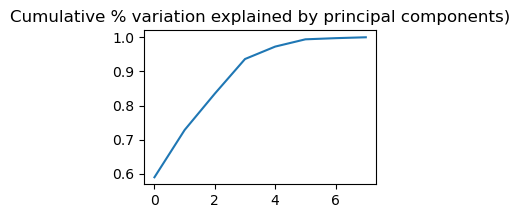

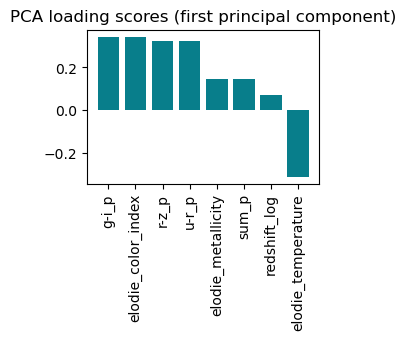

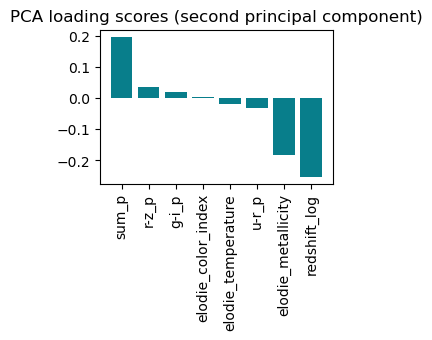


-----X_pca_examples-----


/var/folders/w9/dx4nvr3j01s9jp6j1fm286vc0000gn/T/ipykernel_41465/588417101.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(class_data['PC1'], class_data['PC2'], label=f'Class {label_name}', cmap='viridis', s=1, alpha=0.5)


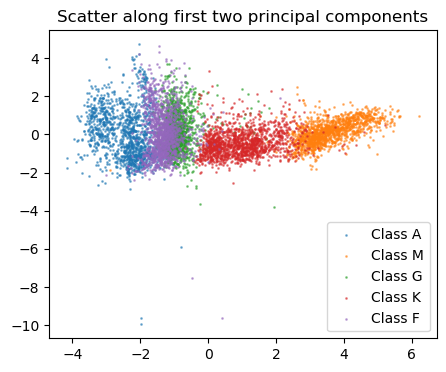

/var/folders/w9/dx4nvr3j01s9jp6j1fm286vc0000gn/T/ipykernel_41465/588417101.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  fig.scatter(class_data['PC2'], class_data['PC3'], class_data['PC1'], label=f'Class {label_name}', cmap='viridis', s=3, alpha=0.4)


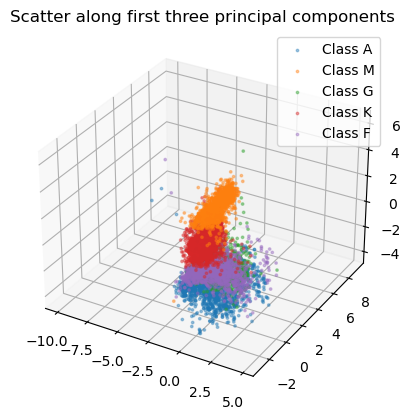

'print(X_pca_examples.shape)\ndisplay(X_pca_examples.head(5))'

In [37]:
# fiting all object_features to a model -- PCA

# setup principal component model
pc = PCA(n_components=3)

# decompose data into principal components (return as ndarrays)
model_pc, history_pc = jsm_fit_model(pc, objects, X0_train, y_train, None, None, 'save')
X7_train = model_pc.transform(X0_train)
X7_validation = model_pc.transform(X0_validation)
X7_test = model_pc.transform(X0_test)
print(X7_train.shape)
print(X7_train[0:5,0:5])

# evaluate principal component explained variance and feature loadings
X_pca_loadings = pca_features(X0_train, features)
"""print(X_pca_loadings.shape)
display(X_pca_loadings.head(5))"""

# plot first two principal components to observe underlying structure
print('\n-----X_pca_examples-----')
X_pca_examples = pca_examples(X7_train, y_train, class_column)
"""print(X_pca_examples.shape)
display(X_pca_examples.head(5))"""

# Investigate Models for Tabular Data

### model_slr: Simple Linear Regression

In [38]:
# define a helper function for visualizing a simple linear regression

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8766577554252053


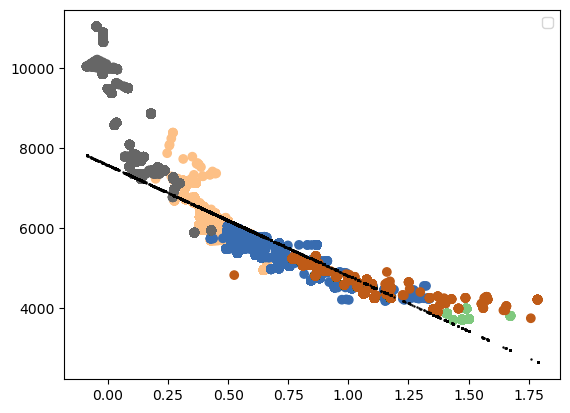

In [39]:
from sklearn import linear_model
import matplotlib.cm as cm

if objects == 'stars':

    # un-transform the feature dataset
    X0_train_untransformed = scaler0.inverse_transform(X0_train)

    # define the dependent variable of interest
    star_y_variable = 'elodie_temperature'
    star_y_idx = 6 #X_train.columns.get_loc(star_y_variable)
    star_y_train = X0_train_untransformed[:, star_y_idx]
    star_y_validation = X0_validation[:, star_y_idx]
    star_y_test = X0_test[:, star_y_idx]

    # define the independent variables of interest
    star_x_variables = ['elodie_color_index'] #['sum_p'] #['sum_p', 'u-r_p', 'g-i_p', 'r-z_p']
    star_x_idx = [X_train.columns.get_loc(star_x_variable) for star_x_variable in star_x_variables]
    star_x_train = X0_train_untransformed[:, star_x_idx]
    star_x_validation = X0_validation[:, star_x_idx]
    star_x_test = X0_test[:, star_x_idx]

    mode = 'level-level'
    if mode == 'level-log':
        star_y_train = np.log(star_y_train)
    elif mode == 'log-level':
        star_x_train = np.log(star_x_train + 1)
    elif mode == 'log-log':
        star_x_train = np.log(star_x_train + 1)
        star_y_train = np.log(star_y_train)

    # setup linear regression
    slr = linear_model.LinearRegression()

    # fit lienar regression model
    model_slr, history_slr = jsm_fit_model(slr, objects, star_x_train, star_y_train, star_x_validation, star_y_validation, mode='save')
    #model_slr = slr.fit(star_x_train, star_y_train)

    print(model_slr.score(star_x_train, star_y_train))

    # plot the outcome
    # NOTE: I have not un-standardized the values!
    plt.scatter(star_x_train[:,0], star_y_train, c=y_train['stellar_subclass_code'], cmap=cm.Accent)
    plt.scatter(star_x_train, model_slr.predict(star_x_train), color='black', s=0.5)
    plt.legend()
    plt.show()


### model_km: k-means Clustering

In [ ]:
# ADD SCATTER PLOT ..................................







	TRAIN SUBSET:
{'Accuracy Score': 0.2936560031738017, 'Precision Score': 0.3215110056126038, 'Recall Score': 0.2936560031738017, 'F1 Score': 0.3065440343843258}
              precision    recall  f1-score   support

           A       0.33      0.31      0.32     27727
           F       0.00      0.00      0.00     27727
           G       0.33      0.26      0.29     27727
           K       0.94      0.90      0.92     27727
           M       0.00      0.00      0.00     27727

    accuracy                           0.29    138635
   macro avg       0.32      0.29      0.31    138635
weighted avg       0.32      0.29      0.31    138635



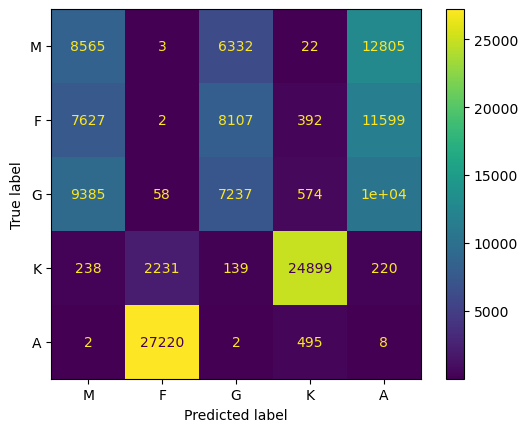


	VALIDATION SUBSET:
{'Accuracy Score': 0.395276330400615, 'Precision Score': 0.4397869353958077, 'Recall Score': 0.395276330400615, 'F1 Score': 0.41289747598138854}
              precision    recall  f1-score   support

           A       0.09      0.30      0.14       621
           F       0.00      0.00      0.00      2733
           G       0.44      0.27      0.33      2880
           K       0.97      0.90      0.93      9239
           M       0.00      0.00      0.00      7941

    accuracy                           0.40     23414
   macro avg       0.30      0.29      0.28     23414
weighted avg       0.44      0.40      0.41     23414



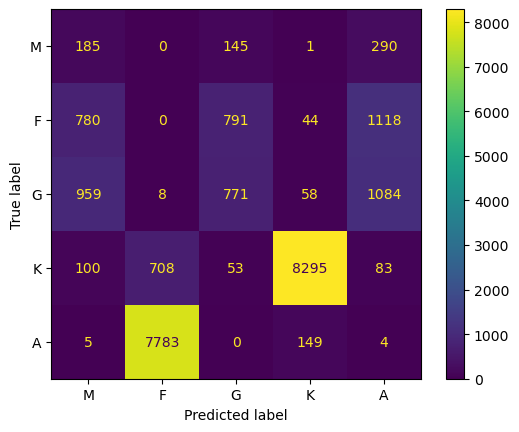

'# make predictions using a model, print performance metrics, then generate a confusion matrix\nprint(f"\n\tVALIDATION SUBSET:")\njsm_predict(model_km, X7_test, y_test)'

In [23]:
# model as k-means clusters

# setup k-means model w/ number of clusters equal to number of known labels
km = KMeans(
    n_clusters=y_train.nunique()[0],
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=1e-04,
    random_state=38
    )

# fit k-means model
model_km, history_km = jsm_fit_model(km, objects, X7_train, y_train.values.ravel(), None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_km, X7_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_km, X7_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_km, X7_test, y_test)"""

### model_knn: K Nearest Neighbors Classifier


	TRAIN SUBSET:
{'Accuracy Score': 0.9950445414217189, 'Precision Score': 0.9950434082152338, 'Recall Score': 0.9950445414217189, 'F1 Score': 0.9950422016808697}
              precision    recall  f1-score   support

           A       1.00      1.00      1.00     27727
           F       0.99      0.99      0.99     27727
           G       0.99      0.99      0.99     27727
           K       1.00      1.00      1.00     27727
           M       1.00      1.00      1.00     27727

    accuracy                           1.00    138635
   macro avg       1.00      1.00      1.00    138635
weighted avg       1.00      1.00      1.00    138635



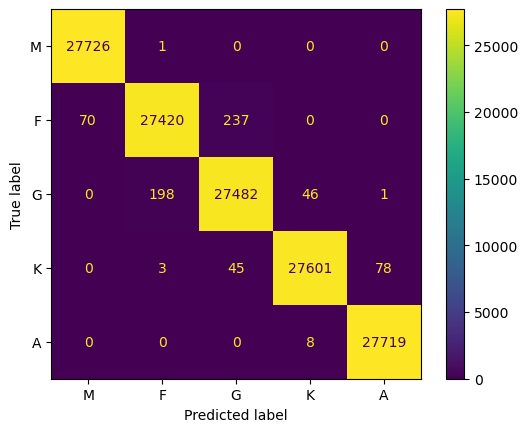


	VALIDATION SUBSET:
{'Accuracy Score': 0.9814640813188691, 'Precision Score': 0.9815405146499179, 'Recall Score': 0.9814640813188691, 'F1 Score': 0.9814435926461428}
              precision    recall  f1-score   support

           A       0.93      0.98      0.95       621
           F       0.95      0.93      0.94      2733
           G       0.94      0.95      0.95      2880
           K       1.00      0.99      0.99      9239
           M       0.99      1.00      1.00      7941

    accuracy                           0.98     23414
   macro avg       0.96      0.97      0.97     23414
weighted avg       0.98      0.98      0.98     23414



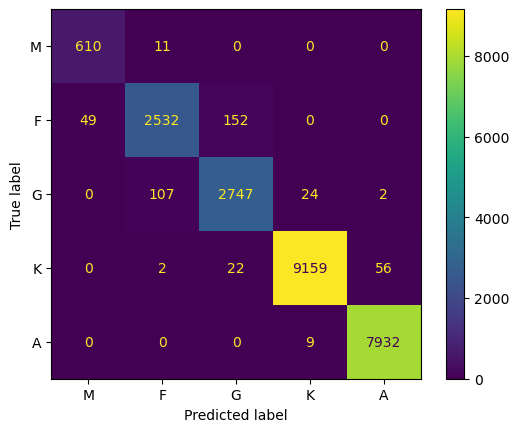

'# make predictions using a model, print performance metrics, then generate a confusion matrix\nprint(f"\n\tVALIDATION SUBSET:")\njsm_predict(model_knn, X0_test, y_test)'

In [24]:
# model as a k nearest neighbors classifier

# setup random forest model
knn = KNeighborsClassifier(n_neighbors=3)

# fit random forest classifier
model_knn, history_knn = jsm_fit_model(knn, objects, X0_train, y_train.values.ravel(), None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_knn, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_knn, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_knn, X0_test, y_test)"""

### model_mlrc: Multiclass Logistic Regression Classifier

/Users/ahmadallaou/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



	TRAIN SUBSET:
{'Accuracy Score': 0.909993868792152, 'Precision Score': 0.9096915351088798, 'Recall Score': 0.909993868792152, 'F1 Score': 0.9097564132520811}
              precision    recall  f1-score   support

           A       0.97      0.99      0.98     27727
           F       0.81      0.80      0.80     27727
           G       0.81      0.82      0.82     27727
           K       0.96      0.98      0.97     27727
           M       1.00      0.97      0.98     27727

    accuracy                           0.91    138635
   macro avg       0.91      0.91      0.91    138635
weighted avg       0.91      0.91      0.91    138635



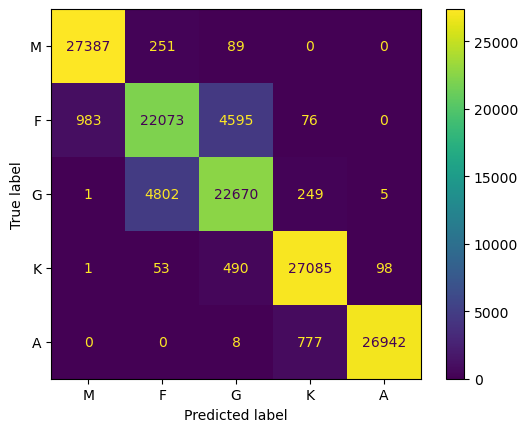


	VALIDATION SUBSET:
{'Accuracy Score': 0.9288459895788844, 'Precision Score': 0.9303282375007128, 'Recall Score': 0.9288459895788844, 'F1 Score': 0.929282041304818}
              precision    recall  f1-score   support

           A       0.84      0.98      0.90       621
           F       0.80      0.77      0.79      2733
           G       0.77      0.81      0.79      2880
           K       0.97      0.97      0.97      9239
           M       0.99      0.97      0.98      7941

    accuracy                           0.93     23414
   macro avg       0.87      0.90      0.89     23414
weighted avg       0.93      0.93      0.93     23414



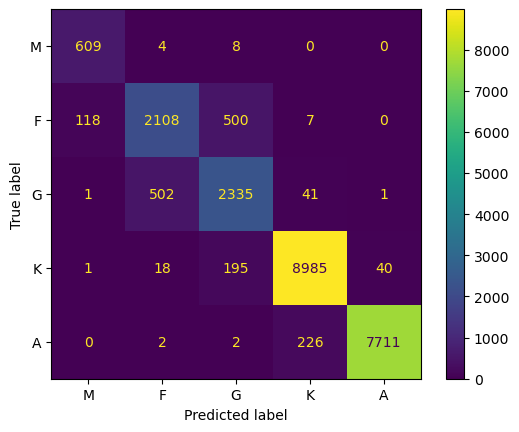

'# make predictions using a model, print performance metrics, then generate a confusion matrix\nprint(f"\n\tVALIDATION SUBSET:")\njsm_predict(model_mlrc, X0_test, y_test)'

In [25]:
# model as a multiclass logistic regression classifier

# setup multiclass logistic regression model
mlrc = LogisticRegression(max_iter=10000, class_weight='balanced', solver='lbfgs', multi_class='ovr')

# fit multiclass logistic regression classifier
model_mlrc, history_mlrc = jsm_fit_model(mlrc, objects, X0_train, y_train, None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_mlrc, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_mlrc, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_mlrc, X0_test, y_test)"""

### model_svc:  Support Vector Machine

/Users/ahmadallaou/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ahmadallaou/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



	TRAIN SUBSET:
{'Accuracy Score': 0.7519818227720273, 'Precision Score': 0.7606316844302332, 'Recall Score': 0.7519818227720273, 'F1 Score': 0.7485051161880945}
              precision    recall  f1-score   support

           A       0.97      0.88      0.92     27727
           F       0.48      0.35      0.41     27727
           G       0.54      0.72      0.62     27727
           K       0.83      0.98      0.90     27727
           M       0.98      0.83      0.90     27727

    accuracy                           0.75    138635
   macro avg       0.76      0.75      0.75    138635
weighted avg       0.76      0.75      0.75    138635



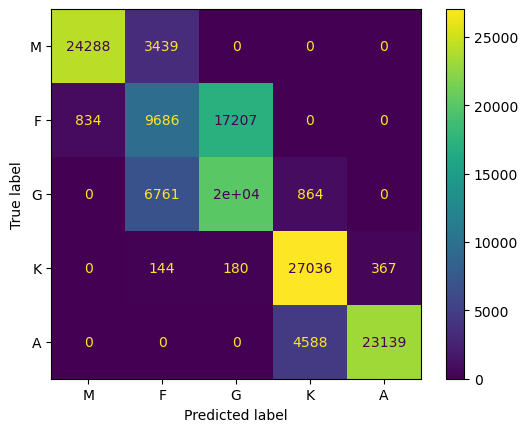


	VALIDATION SUBSET:
{'Accuracy Score': 0.8153241650294696, 'Precision Score': 0.8212072356182535, 'Recall Score': 0.8153241650294696, 'F1 Score': 0.8124507925370145}
              precision    recall  f1-score   support

           A       0.84      0.79      0.81       621
           F       0.50      0.36      0.42      2733
           G       0.54      0.70      0.61      2880
           K       0.87      0.97      0.92      9239
           M       0.98      0.84      0.90      7941

    accuracy                           0.82     23414
   macro avg       0.74      0.73      0.73     23414
weighted avg       0.82      0.82      0.81     23414



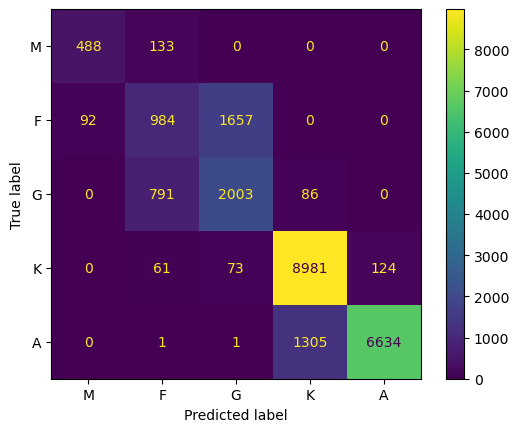

'# make predictions using a model, print performance metrics, then generate a confusion matrix\nprint(f"\n\tVALIDATION SUBSET:")\njsm_predict(model_svc, X0_test, y_test)'

In [26]:
# model as a support verctor machine classifier

# setup support vector machine model
svc = SVC(max_iter=100, class_weight='balanced', decision_function_shape='ovr')

# fit msupport verctor machine classifier
model_svc, history_svc = jsm_fit_model(svc, objects, X0_train, y_train, None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_svc, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_svc, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_svc, X0_test, y_test)"""

In [ ]:
model = jsm_fit_model(blahblah)

### model_dt:  Decision Tree Classifier

In [ ]:
# model as decision tree classifier
 
# setup decision tree model
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=5)#, class_weight = {}#class_weight={0:1.1, 1:1, 2:1.15}, random_state=5)

# fit random forest classifier
model_dt, history_dt = jsm_fit_model(dt, objects, X0_train, y_train, None, None, 'save')
"""dt.fit(X0_train, y_train)"""

# plot decision tree
plt.figure(figsize=(1.25, 1.25), dpi=600)
class_names = sorted(y_train[class_column[0]].unique())
class_names = [str(value) for value in class_names]
tree.plot_tree(model_dt, filled=True, label='none', feature_names=features, class_names=class_names, max_depth=2, proportion=True, impurity=False, precision=1)
#tree.plot_tree(model_dt, filled=True, label='none', feature_names=features, class_names=class_names, max_depth=2, proportion=True, impurity=False, precision=1)
#plt.figure(figsize=(1.25, 1.25), dpi=600)
plt.show()

# make predictions using a model, print performance metrics, then generSate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_dt, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_dt, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_dt, X0_test, y_test)"""

### model_rf:  Random Forest Classifier


	TRAIN SUBSET:
{'Accuracy Score': 0.9350957550402135, 'Precision Score': 0.9347595451372631, 'Recall Score': 0.9350957550402135, 'F1 Score': 0.9344499444380583}
              precision    recall  f1-score   support

           A       0.96      0.93      0.94     27727
           F       0.88      0.82      0.85     27727
           G       0.90      0.93      0.91     27727
           K       0.94      0.99      0.97     27727
           M       1.00      1.00      1.00     27727

    accuracy                           0.94    138635
   macro avg       0.93      0.94      0.93    138635
weighted avg       0.93      0.94      0.93    138635



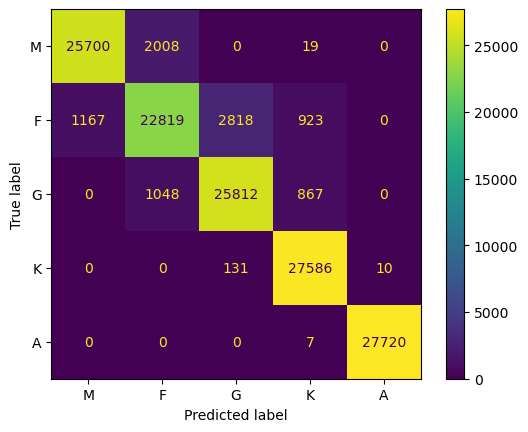


	VALIDATION SUBSET:
{'Accuracy Score': 0.9651917656103186, 'Precision Score': 0.9655064190799535, 'Recall Score': 0.9651917656103186, 'F1 Score': 0.9647299414632959}
              precision    recall  f1-score   support

           A       0.81      0.94      0.87       621
           F       0.93      0.82      0.87      2733
           G       0.89      0.92      0.91      2880
           K       0.98      1.00      0.99      9239
           M       1.00      1.00      1.00      7941

    accuracy                           0.97     23414
   macro avg       0.92      0.93      0.93     23414
weighted avg       0.97      0.97      0.96     23414



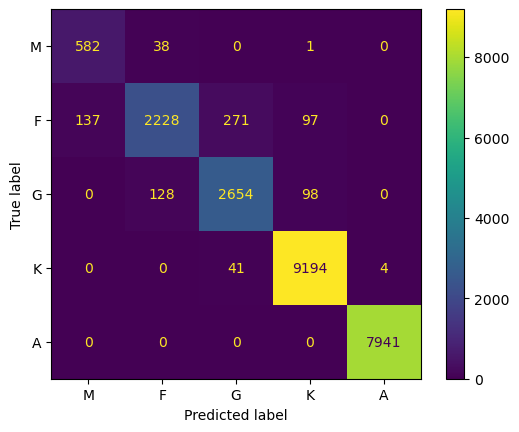

'# make predictions using a model, print performance metrics, then generate a confusion matrix\nprint(f"\n\tVALIDATION SUBSET:")\njsm_predict(model_rf, X0_test, y_test)'

In [26]:
# model as a random forest classifier

# setup random forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=38)

# fit random forest classifier
model_rf, history_rf = jsm_fit_model(rf, objects, X0_train, y_train.values.ravel(), None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_rf, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_rf, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_rf, X0_test, y_test)"""


### model_mlp: Multilayer Perceptron Model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               2304      
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 5)                 645       
                                                                 
Total params: 35,845
Trainable params: 35,845
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
68/68 [==============================] - 1s 8ms/step - loss: 0.2881 - accuracy: 0.8913 - val_loss: 0.0993 - val_accuracy: 0.9743
Epoch 2/5
68/68 [==============================] - 0s 6ms/step - loss: 0.0964 - accuracy: 0.9699 - val_loss: 0.0645 - val_accuracy: 0.9799
Epoch 3/5
68/68 [==============

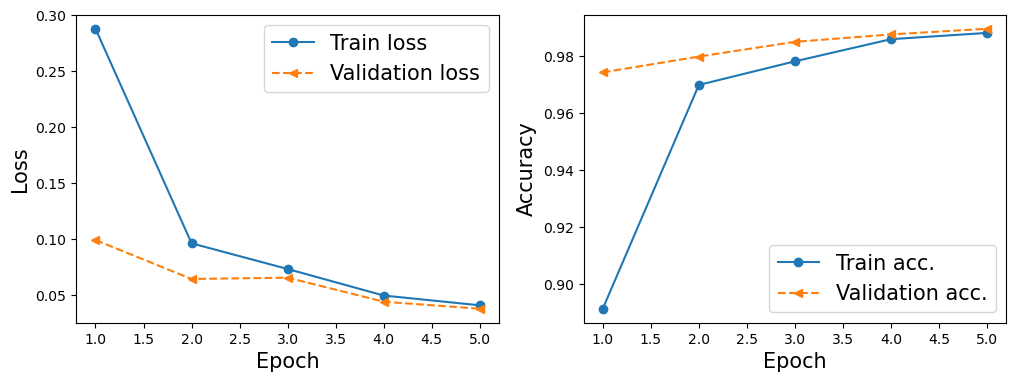


	TRAIN SUBSET:
4333/4333 [==============================] - 2s 550us/step
{'Accuracy Score': 0.9892235005590219, 'Precision Score': 0.9892141264128733, 'Recall Score': 0.9892235005590219, 'F1 Score': 0.9892051761362595}
              precision    recall  f1-score   support

           A       0.99      1.00      0.99     27727
           F       0.98      0.98      0.98     27727
           G       0.99      0.98      0.98     27727
           K       0.99      0.99      0.99     27727
           M       1.00      1.00      1.00     27727

    accuracy                           0.99    138635
   macro avg       0.99      0.99      0.99    138635
weighted avg       0.99      0.99      0.99    138635



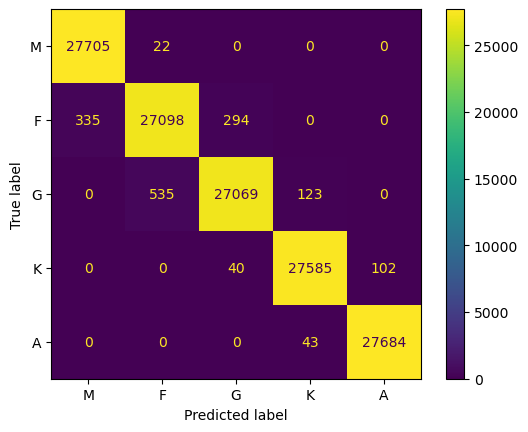


	VALIDATION SUBSET:
732/732 [==============================] - 0s 519us/step
{'Accuracy Score': 0.9896643034082173, 'Precision Score': 0.9897894049199673, 'Recall Score': 0.9896643034082173, 'F1 Score': 0.9896831134330816}
              precision    recall  f1-score   support

           A       0.92      1.00      0.96       621
           F       0.98      0.97      0.97      2733
           G       0.98      0.97      0.98      2880
           K       1.00      0.99      0.99      9239
           M       0.99      1.00      1.00      7941

    accuracy                           0.99     23414
   macro avg       0.97      0.99      0.98     23414
weighted avg       0.99      0.99      0.99     23414



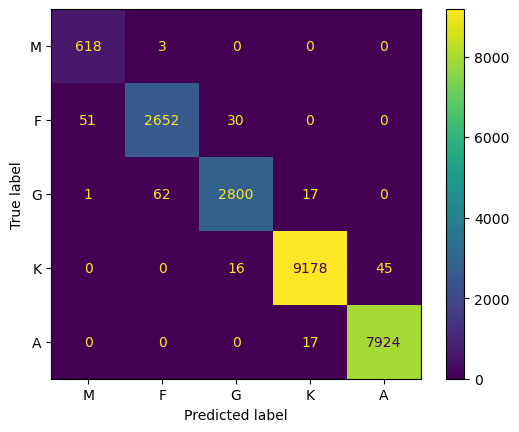

'# make predictions using a model, print performance metrics, then generate a confusion matrix\nprint(f"\n\tVALIDATION SUBSET:")\njsm_predict(model_mlp, X0_test, y_test)'

In [40]:
# model as a multiclass logistic regression classifier
# NOTE: using two hidden layers

# setup multiclass logistic regression model
mlp = keras.Sequential([
    layers.Dense(
        units=256   ,              # output dim
        input_shape=[X_train.shape[1]],             # input dim
        use_bias=True,                              # we included the bias in X
        activation='relu',                          # apply a sigmoid to the output
        kernel_initializer='random_normal',         # initialize params to small random numbers
        bias_initializer='zeros'                    # initialize biases to 0
    ),
    layers.Dense(
        units=128,                                  # output dim
        use_bias=True,                              # we included the bias in X
        activation='relu',                          # apply a sigmoid to the output
        kernel_initializer='random_normal',         # initialize params to small random numbers
        bias_initializer='zeros'                    # initialize biases to 0
    ),
    layers.Dense(
        units=y_train.nunique()[0],                 # output dim
        use_bias=True,                              # we included the bias in X
        activation='softmax',                       # apply a sigmoid to the output
        kernel_initializer='random_normal',         # initialize params to small random numbers
        bias_initializer='zeros'                    # initialize biases to 0
    )
])
print(mlp.summary())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
mlp.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# fit multiclass logistic regression classifier
model_mlp, history_mlp = jsm_fit_model(mlp, objects, X0_train, y_train, X0_validation, y_validation, 'save', epochs=5, batch_size=2048, verbose=1) # quick training:  epochs=3, batch_size=65536, verbose=1

# plot performance history
jsm_plot_history(history_mlp)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_mlp, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_mlp, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_mlp, X0_test, y_test)"""

# Summarization of Results

In [ ]:



# HYPERPARAMETER TUNING:  FOR EACH TASK/MODEL, VARY REBALANCING MODE, VARY X dataset (X0 vs. X7), VARY 2-5 HYPERPARAMETERS W/ 2-5 VALUES...
#                   THEN DOCUMENT METRICS (INCLUDING RUN-TIME)
# ADD CODE FOR FINAL EVALUATION OF TEST SET (ON CHOSEN HYPERPARAMETERS)
#                   if possible, including a histogram of boxplot of metrics based on k-fold validation
# FOR EACH TASK/MODEL, DOCUMENT METRICS (INCLUDING RUN-TIME)

732/732 [==============================] - 0s 493us/step
{'Accuracy Score': 0.9903907751441384, 'Precision Score': 0.9904525254853741, 'Recall Score': 0.9903907751441384, 'F1 Score': 0.9904014569477785}
              precision    recall  f1-score   support

           A       0.94      1.00      0.97       569
           F       0.98      0.97      0.97      2674
           G       0.97      0.98      0.97      2839
           K       1.00      0.99      1.00      9204
           M       1.00      1.00      1.00      8129

    accuracy                           0.99     23415
   macro avg       0.98      0.99      0.98     23415
weighted avg       0.99      0.99      0.99     23415



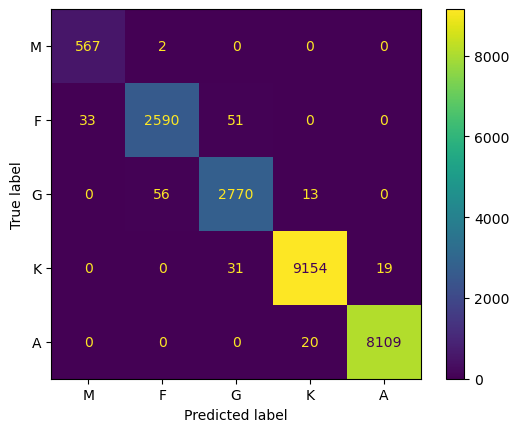

In [29]:
jsm_predict(model_mlp,X0_test,y_test)

## Moving Onto the Image Classification

In [17]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [18]:
samp_gal = sdss_secondary[sdss_secondary['gz2_filenumber'].isna() == False].sample(n=5000,random_state=42)

In [19]:
IMAGE_PATH = '../data/images/' # replace with your path

In [20]:
img_data = []

In [21]:
identifiers = set(samp_gal['gz2_filenumber'])

for idx, name in enumerate(os.listdir(IMAGE_PATH)):
    temp = {}
    if name.endswith('.jpg'):
        file_identifier = name.split('.')[0]
        if file_identifier in identifiers:
            temp['identifier'] = file_identifier
            temp['gz2_subclass_code'] =  samp_gal[samp_gal['gz2_filenumber'] == file_identifier]['gz2_subclass_code'].iloc[0]
            temp['imgdata'] = load_img(IMAGE_PATH + name,target_size=(224,224))
            img_data.append(temp)


In [22]:
img_df = pd.DataFrame(img_data)

In [40]:
img_df.shape

(4997, 3)

In [23]:
samp5 = img_df.sample(n=5,random_state=42)

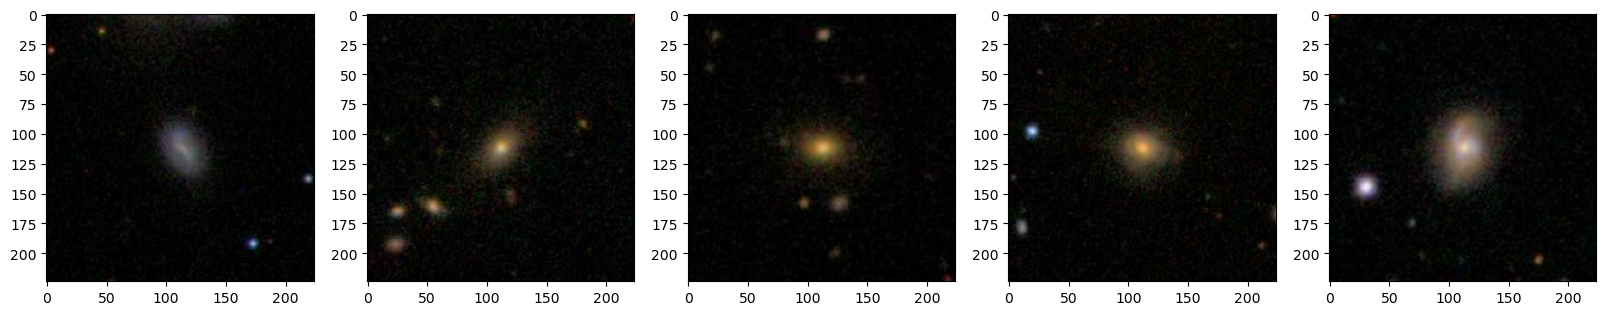

In [24]:
#show images of the sampled galaxies
nrows, ncols = 1,5
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(ncols):
        axs[i].imshow(samp5['imgdata'].iloc[i])

In [25]:
def preprocess_data_part1(df):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, row in df.iterrows():
        y_mini.append(row['gz2_subclass_code'])
        
        # transform image to array
        temp_img = img_to_array(row['imgdata'])
        
        # append to images
        images_mini.append(temp_img)
       

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [26]:
img_arr, y_arr = preprocess_data_part1(img_df)

In [42]:
img_arr.shape

(4997, 224, 224, 3)

In [27]:
CONTRAST_FACTOR = 5
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 424, 424, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0],splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0],splits[0]+splits[1]])
    ### image transformation on training, validation, and test data ###
    ###################################################################


    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [28]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    img_arr,
    y_arr,
    split=(0.6,0.2,0.2)
)

In [29]:
X_train

<tf.Tensor: shape=(5996, 224, 224, 3), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        ],
         [0.00392157, 0.00392157, 0.00392157],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.        , 0.00784314, 0.00392157],
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00392157, 0.        ]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.00392157, 0.01176471, 0.00784314],
         [0.        , 0.00784314, 0.00392157],
         [0.        , 0.00392157, 0.        ]],

        [[0.02352941, 0.02352941, 0.02352941],
         [0.01568628, 0.01568628, 0.01568628],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.00392157, 0.01176471, 0.00784314],
         [0.00392157, 0.01176471, 0.00784314],
         [0.        , 0.00784314, 0.00392157]],

        ...,

        [[0.01176471, 0.0117647

In [47]:
from tensorflow.keras import backend as K

# Clear the session
K.clear_session()

# # Redefine and recompile the model here
# model = ...  # your model definition
# model.compile(...)  # model compilation

# # Then fit the model
# history = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_val, y_val_encoded))

In [48]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [49]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [50]:
for layer in base_model.layers:
    layer.trainable = False

In [51]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
img_arr.shape

(4997, 224, 224, 3)

In [45]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=10)
y_val_encoded = to_categorical(y_val, num_classes=10)

In [53]:
history = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_val, y_val_encoded))

Epoch 1/5
188/188 [==============================] - 529s 3s/step - loss: 1.9461 - accuracy: 0.2287 - val_loss: 1.8797 - val_accuracy: 0.2152
Epoch 2/5
188/188 [==============================] - 563s 3s/step - loss: 1.8518 - accuracy: 0.2617 - val_loss: 1.8897 - val_accuracy: 0.2633
Epoch 3/5
188/188 [==============================] - 526s 3s/step - loss: 1.8366 - accuracy: 0.2638 - val_loss: 1.8817 - val_accuracy: 0.2633
Epoch 4/5
188/188 [==============================] - 652s 3s/step - loss: 1.8293 - accuracy: 0.2625 - val_loss: 1.8856 - val_accuracy: 0.2402
Epoch 5/5
188/188 [==============================] - 666s 4s/step - loss: 1.8069 - accuracy: 0.2723 - val_loss: 1.8790 - val_accuracy: 0.2633


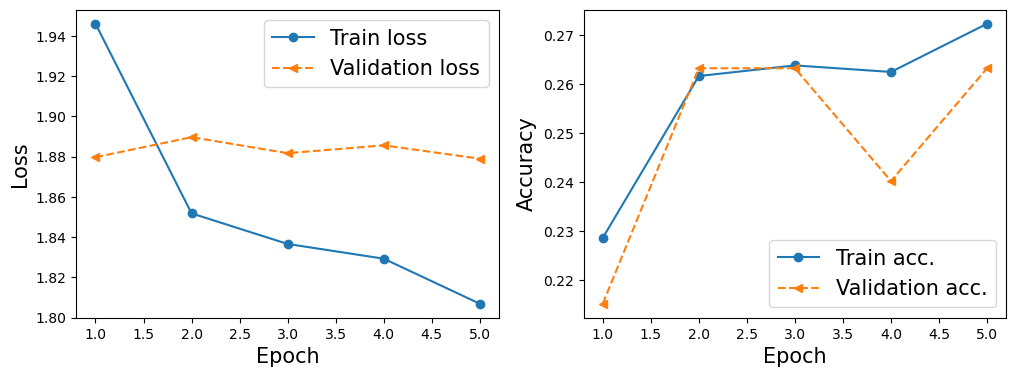

In [58]:
x_arr = np.arange(len(history.history['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, history.history['loss'], '-o', label='Train loss')
ax.plot(x_arr, history.history['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, history.history['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, history.history['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [35]:
X_train.shape

TensorShape([5996, 224, 224, 3])

In [43]:
y_train.shape

(5996,)

In [37]:
X_val.shape

(999, 224, 224, 3)

In [39]:
X_test.shape

(1000, 224, 224, 3)

In [44]:
y_val.shape

(999,)